# Imports

In [11]:
import os
import imageio.v3 as iio
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from keras import applications
from keras.models import Sequential
from keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report

# 1. Objectives

The main objective of the analysis is to classify X-ray images of pediatric patients as 'Normal' or representative of 'Pneumonia' present in the patient. Human classification of medical images can be prone to cognitive biases and while Machine learning models such as Neural Networks are not immune to biases, a machine learning model could potentially be a useful tool to aid diagnosis.

Convolutional Neural Network based models (CNNs) have been demonstated with state-of-the art performance in various image classification tasks, for example on the famous MNIST digit recognition dataset:
https://paperswithcode.com/sota/image-classification-on-mnist

For this analysis 3 variations of a CNN will be trained on the dataset:

* **Baseline CNN model**
    * A simple CNN using a sequence of comvolutional layers, Max pooling layers and dropout layers
    
* **Baseline CNN model with data augmentation**
    * Add an image augmentation layer prior to the baseline model. This should add randomness into the model to help with overfitting
    
* **CNN model incorporating transfer learning**
    * Transfer learning is a powerful tool whereby a pre-trained model can be used as the base for a new neural network model. The pre-trained model could be a state-of-the-art model trained on a huge dataset. Additional layers can be added to the base model as desired, but the base model 'frozen' so that training is only done on the additional layers, to reduce training time. Transfer learning is dependent on the similarity between the datasets used to train the base model and the new model
    
The models will be evaluated based on various metrics:
* Accuracy score
* Precision
* Recall

We will prioritise recall over precision as it is better to capture as many positive cases as possible at the expense of more false positives than to reduce the false positive rate at the expense of capturing fewer actual positives. <br>

A confusion matrix will be generated to show the false positive and false negative rate.

# 2. Data description

The dataset is available here:
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). The images are 'grayscale', i.e have an image depth of 1 and have various image sizes and aspect ratios

Chest X-ray images were selected from pediatric patients, one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

Some considerations/issues to take into account for the modelling process include:
* Image sizes in the datasets are all different, so the images will have to be rescaled to a common image size for input into the neural network models
* The dataset is imbalanced so resampling or adjustment of the weights should be used to ensure the minority class is properly represented
* The dataset is relatively small so we will have to be careful not to overfit. We will use dropout layers in the model to try and limit overfitting.

# 3. Data loading, exploration and pre-processing

Define the directories

In [12]:
data_dir = os.path.join('data','train')
data_dir_test = os.path.join('data','test')
data_dir_val = os.path.join('data','val')

Check the image sizes for a selection of 10 images

In [13]:
for i in glob.glob(os.path.join(data_dir, 'NORMAL', '*.jpeg'))[:10]:
    height, width = iio.imread(i).shape
    print('height = {}, width = {}'.format(height, width))

height = 1858, width = 2090
height = 1152, width = 1422
height = 1434, width = 1810
height = 1279, width = 1618
height = 1125, width = 1600
height = 1306, width = 1974
height = 1013, width = 1528
height = 1167, width = 1384
height = 1144, width = 1450
height = 993, width = 1468


* The images are of various dimensions. These will be resized to 256 * 256 pixels images as part of the data load function. 

Define a function to load data from a directory:

In [1]:
def load_dataset(directory, color_mode='grayscale', validation_split=0, subset=None):
    
    '''Create a Keras BatchDataset object from a directory. Can use the validation_split
    parameter to split part of the data into a validation set.'''
    
    dataset = image_dataset_from_directory(
        directory,
        label_mode='binary',
        color_mode=color_mode,
        validation_split=validation_split,
        subset=subset,
        seed=111,
        image_size=(256, 256),
        batch_size=32)
    return dataset

The images are split into a train and test directory. <br>
Split the train directory into a train and validation set. <br> 
The test set is loaded from a the test directory. <br>
Within each directory are 2 folders named 'NORMAL' and 'PNEUMONIA'. Keras will treat these as the 2 classes in the dataset.

In [15]:
print('Loading train and validation sets:')
train_data, val_data  = load_dataset(data_dir, validation_split=0.1, subset='both')
print('Loading test set:')
test_data = load_dataset(data_dir_test)

Loading train and validation sets:
Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Using 521 files for validation.
Loading test set:
Found 624 files belonging to 2 classes.


Check the class names

In [16]:
class_names = train_data.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


Check the shape of the train data

In [17]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 1)
(32, 1)


* The train data is organised into batches of 32 images of dimension 256 x 256 pixel images of depth 1 (grayscale). <br>
* For each image there is a label of dimension 1

Visualise a selection of 10 of the images

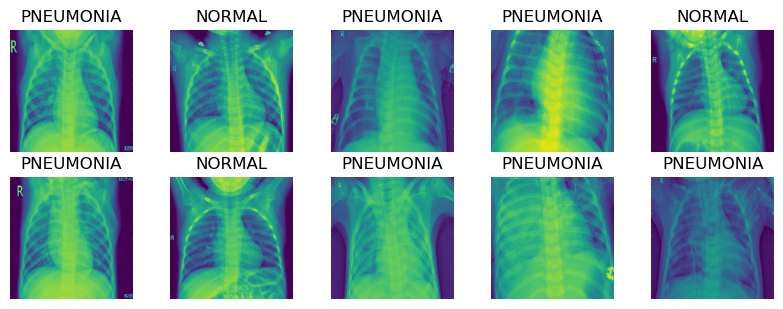

In [18]:
plt.figure(figsize=(10, 3.5))

for images, labels in train_data.take(1):
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i][0].numpy().astype("uint8")])
    plt.axis("off")

Get the ratio of the positive class (pneumonia) to the negative class (normal)

proportion of observations in positive class = 0.742


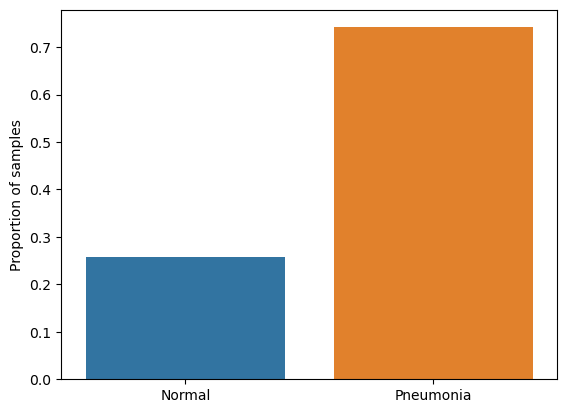

In [19]:
# Get ratio of positive to negative class
s = train_data.unbatch()
class_ratio = np.mean([labels.numpy()[0] for images, labels in s])
print("proportion of observations in positive class = {:.3f}".format(class_ratio))

sns.barplot(x = ['Normal','Pneumonia'], y=[1-class_ratio, class_ratio])
plt.ylabel('Proportion of samples')
plt.show()

As the negative class is under-represented in the dataset, calculate weights so that the negative class is weighted corresponding more than the positive class

In [20]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = 1
weight_for_0 = (1 / (1-class_ratio)) * (total / 2.0)  # Negative class
weight_for_1 = (1 / class_ratio) * (total / 2.0)  # Positive class

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


Finally, the images will be rescaled into a range from 0 to 1 for input into the neural network. This will be done using a rescaling layer as part of the model definition.

# 4. Baseline CNN model

Define a simple CNN model using Convolutional layers, Max pooling layers and dropout layers. <br>
A 128 node fully connected layer is connected to a sigmoid activation for the classification.

In [21]:
rescaling_layer = keras.Sequential([
  keras.layers.Rescaling(1./255)
])

baseline_model = keras.Sequential([ 
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Dropout(0.5),
    
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Dropout(0.5),
    
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(1, activation='sigmoid')
])

In [22]:
model_1 = keras.Sequential([
    rescaling_layer,
    baseline_model
])

Define a function to compile and fit the model

In [23]:
def compile_and_fit(model, epochs, train_data=train_data, val_data=val_data):
    
    batch_size=32
    # initiate Adam optimizer
    opt = keras.optimizers.Adam()
    
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    history = model.fit(train_data,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(val_data),
                  shuffle=True,
                  class_weight=class_weight)
    
    return model, history

Train the model for 6 epochs

In [24]:
model_1, history_1 = compile_and_fit(model_1, 6)

Epoch 1/6
147/147 [==============================] - 242s 2s/step - loss: 1.0500 - accuracy: 0.5972 - val_loss: 0.3923 - val_accuracy: 0.8464
Epoch 2/6
147/147 [==============================] - 250s 2s/step - loss: 0.2434 - accuracy: 0.9082 - val_loss: 0.2002 - val_accuracy: 0.9290
Epoch 3/6
147/147 [==============================] - 359s 2s/step - loss: 0.1619 - accuracy: 0.9378 - val_loss: 0.1391 - val_accuracy: 0.9520
Epoch 4/6
147/147 [==============================] - 571s 4s/step - loss: 0.1377 - accuracy: 0.9448 - val_loss: 0.1094 - val_accuracy: 0.9578
Epoch 5/6
147/147 [==============================] - 397s 3s/step - loss: 0.1291 - accuracy: 0.9538 - val_loss: 0.1124 - val_accuracy: 0.9597
Epoch 6/6
147/147 [==============================] - 232s 2s/step - loss: 0.1000 - accuracy: 0.9623 - val_loss: 0.0957 - val_accuracy: 0.9674


Define a function to plot the training history

In [26]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  plt.figure(figsize=(10,3))
  for n, metric in enumerate(metrics):
    plt.subplot(1,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()

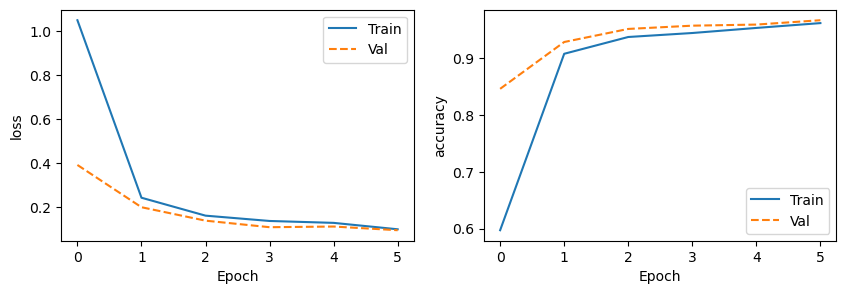

In [27]:
plot_metrics(history_1)

* The Train and validation loss improve with more epochs, but have started to pleateau after 6 epochs
* The dropout layer is not used for the validation data, so we expect that the accuracy could be better for the validation set

Define a function to evaluate the loss and accuracy score

In [28]:
def evaluate_model(model, dataset, name='test', batch_size=32):
    
    loss, score = model.evaluate(dataset, batch_size=batch_size)
    print("Loss on {} set: ".format(name), loss)
    print("Accuracy on {} set: ".format(name), score)
    
    return loss, score

In [29]:
# Evaluation on test datasets
test_1_loss, test_1_score = evaluate_model(model_1, test_data)

20/20 [==============================] - 8s 355ms/step - loss: 0.7005 - accuracy: 0.7949
Loss on test set:  0.700505256652832
Accuracy on test set:  0.7948718070983887


* The test accuracy is much lower than the train accuracy which suggests that there could be some overfitting on the training data.
* But, it is suprising that the test accuracy is so much lower than the validation accuracy as neither dataset was used to train the model.

A function to get the prediction and label (true value) for each example in the dataset. Need to make sure that the preidction and label are matched up to the same example.

In [30]:
def get_preds(dataset, model):
    i=0
    for x, y in dataset:
      if i == 0:
        preds = model.predict(x, verbose='False')
        labels = y.numpy()
      preds = np.concatenate([preds, model.predict(x, verbose='False')])
      labels = np.concatenate([labels, y.numpy()])
      i += 1
    return preds, labels

In [31]:
preds_1_test, labels_1_test = get_preds(test_data, model_1)

In [32]:
print(classification_report((preds_1_test>0.5).astype(int), labels_1_test))

              precision    recall  f1-score   support

           0       0.47      0.95      0.63       122
           1       0.99      0.76      0.86       534

    accuracy                           0.79       656
   macro avg       0.73      0.85      0.74       656
weighted avg       0.89      0.79      0.81       656



* High recall but lower precision.
    * The model is accurate at predicting pneumonia at the expense of a high false positive rate

Function to plot the confusion matrix

In [33]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total positives: ', np.sum(cm[1]))

True Negatives:  116
False Positives:  130
False Negatives:  6
True Positives:  404
Total positives:  410


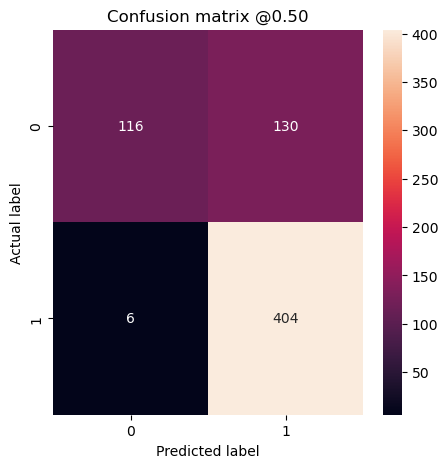

In [34]:
plot_cm(labels_1_test, preds_1_test)

* The confusion matrix confirms a low false negative rate but a fairly high false positive rate

# 5. Baseline model with data augmentation

Create a augmentation layer to add a random horizontal flip, rotation and zoom to the data.
This should add randomness to the training set to help reduce overfitting.

In [35]:
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip("horizontal"),
  keras.layers.RandomRotation(0.2),
  keras.layers.RandomZoom(0.1),  
])

Create a model by starting with the augmentation layer then adding the rescaling layer and baseline model on sequentially

In [36]:
model_2 = keras.Sequential([
  data_augmentation,  
  rescaling_layer,
  baseline_model,
])

Fit this model for 6 epochs as per the baseline model

In [37]:
model_2, history_2 = compile_and_fit(model_2, 6)

Epoch 1/6
147/147 [==============================] - 253s 2s/step - loss: 0.5063 - accuracy: 0.7791 - val_loss: 0.2241 - val_accuracy: 0.9175
Epoch 2/6
147/147 [==============================] - 249s 2s/step - loss: 0.3454 - accuracy: 0.8592 - val_loss: 0.1863 - val_accuracy: 0.9251
Epoch 3/6
147/147 [==============================] - 251s 2s/step - loss: 0.2700 - accuracy: 0.8958 - val_loss: 0.1693 - val_accuracy: 0.9386
Epoch 4/6
147/147 [==============================] - 241s 2s/step - loss: 0.2444 - accuracy: 0.9050 - val_loss: 0.2119 - val_accuracy: 0.9367
Epoch 5/6
147/147 [==============================] - 241s 2s/step - loss: 0.2238 - accuracy: 0.9144 - val_loss: 0.1889 - val_accuracy: 0.9232
Epoch 6/6
147/147 [==============================] - 239s 2s/step - loss: 0.2200 - accuracy: 0.9174 - val_loss: 0.1720 - val_accuracy: 0.9482


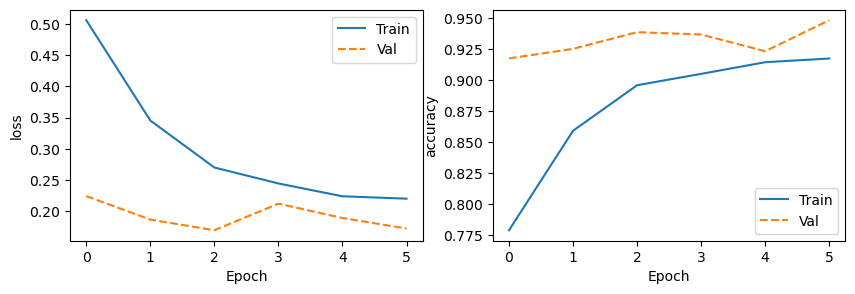

In [39]:
plot_metrics(history_2)

In [40]:
# Evaluation on test dataset
test_2_loss, test_2_score = evaluate_model(model_2, test_data, 'test')

20/20 [==============================] - 8s 369ms/step - loss: 0.4250 - accuracy: 0.8558
Loss on test set:  0.42499181628227234
Accuracy on test set:  0.8557692170143127


In [41]:
preds_2_test, labels_2_test = get_preds(test_data, model_2)

In [42]:
print(classification_report((preds_2_test>0.5).astype(int), labels_2_test))

              precision    recall  f1-score   support

           0       0.66      0.93      0.77       174
           1       0.97      0.83      0.89       482

    accuracy                           0.85       656
   macro avg       0.81      0.88      0.83       656
weighted avg       0.89      0.85      0.86       656



* Accuracy is significantly better than the baseline model even though the training accuracy is worse, suggesting that the augmentation layer has significantly reduced overfitting 
* Recall is slightly lower but precision is significantly higher than the baseline model

True Negatives:  162
False Positives:  84
False Negatives:  12
True Positives:  398
Total positives:  410


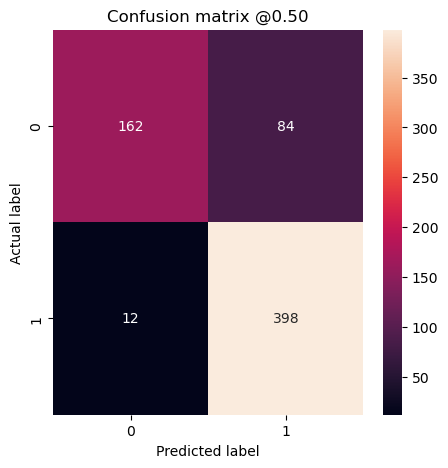

In [43]:
plot_cm(labels_2_test, preds_2_test)

* Owing to the improved recall, the amount of false positives is much lower
* Slightly higher false negative rate which reflects the lower precision value

# 6. CNN model with transfer learning

Load the datasets. As we will be using the 'Xception' model for our base model we will resample each image into 3 channels (RGB) as this is what the base model expects.

In [44]:
print('Loading train and validation sets:')
train_data_rgb, val_data_rgb  = load_dataset(data_dir, color_mode='rgb', validation_split=0.1, subset='both')
print('Loading test set:')
test_data_rgb = load_dataset(data_dir_test, color_mode='rgb')

Loading train and validation sets:
Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Using 521 files for validation.
Loading test set:
Found 624 files belonging to 2 classes.


Xception is a deep CNN architecture that involves Depthwise Separable Convolutions. It has achieved very high good accuracy on the 'ImageNet' dataset. Xception is a very deep model incorporating many layers.

In [45]:
base_model = applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

It will be very computationally expensive to try and train the entire model, so we freeze the base model and only train on the additional layers

In [46]:
base_model.trainable = False

Add to the base model a flatten layer then a fully connected layer and finally a sigmoid activation to do the classification.

In [47]:
inputs = keras.Input(shape=(256, 256, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)
model_3 = keras.Model(inputs, outputs)

Train for 4 epochs

In [48]:
model_3, history_3 = compile_and_fit(model_3, 4, train_data=train_data_rgb, val_data=val_data_rgb)

Epoch 1/4
147/147 [==============================] - 856s 6s/step - loss: 17.7334 - accuracy: 0.8573 - val_loss: 0.5440 - val_accuracy: 0.9232
Epoch 2/4
147/147 [==============================] - 920s 6s/step - loss: 0.9514 - accuracy: 0.8456 - val_loss: 0.6006 - val_accuracy: 0.8772
Epoch 3/4
147/147 [==============================] - 1049s 7s/step - loss: 0.5127 - accuracy: 0.8147 - val_loss: 0.4129 - val_accuracy: 0.9309
Epoch 4/4
147/147 [==============================] - 984s 7s/step - loss: 0.4279 - accuracy: 0.8684 - val_loss: 0.5077 - val_accuracy: 0.9424


* This model is very deep with a large number of trainable parameters

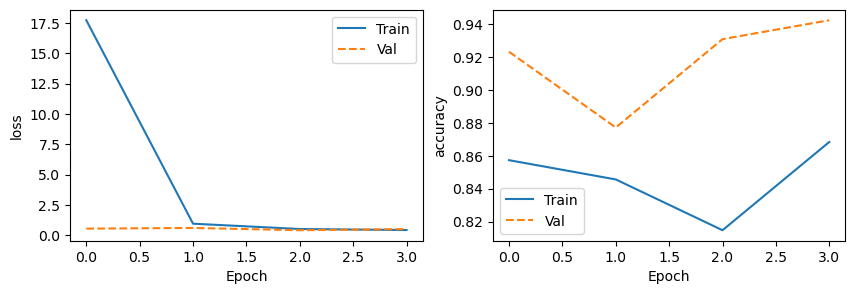

In [50]:
plot_metrics(history_3)

In [51]:
# Evaluation on test dataset
test_3_loss, test_3_score = evaluate_model(model_3, test_data_rgb, 'test')

20/20 [==============================] - 125s 6s/step - loss: 0.8444 - accuracy: 0.8109
Loss on test set:  0.8443939089775085
Accuracy on test set:  0.8108974099159241


In [52]:
preds_3_test, labels_3_test = get_preds(test_data_rgb, model_3)

In [53]:
print(classification_report((preds_3_test>0.5).astype(int), labels_3_test))

              precision    recall  f1-score   support

           0       0.57      0.90      0.70       156
           1       0.96      0.79      0.87       500

    accuracy                           0.81       656
   macro avg       0.77      0.84      0.78       656
weighted avg       0.87      0.81      0.83       656



* Accuracy lower than the previous 2 models 
* Fairly high recall but the model predicts a large number of false positives

True Negatives:  140
False Positives:  106
False Negatives:  16
True Positives:  394
Total positives:  410


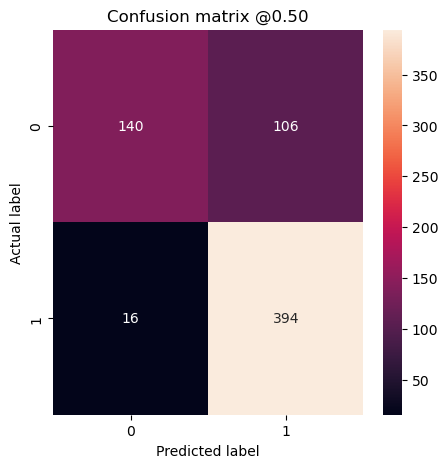

In [54]:
plot_cm(labels_3_test, preds_3_test)

# 7. Recommendations

As per the objectives of the exercise the models were evaluated based on the following metrics:
* Accuracy score
* Precision
* Recall

Recall was decided to be more important as we prefer to capture as many of the true positives as possible as the expense of some false positives. But we still want the model to have reasonable precision.

* The baseline model had the best recall, but the precision was only 0.47
* The baseline model with augmentation had the best accuracy and precision, with the precision significanty better than the first model at 0.66. Accuracy was also the best out of the 3 models. Recall was only slightly worse
* The transfer learning model had a low accuracy and precision

Choose model 2 (Baseline with augmentation) as best meeting the requirements


# 8. Findings and Insights

Considering that the 74% of the examples were positive for 'pneumonia' we could achieve an accuracy of 0.74 just by predicting all cases as being positive.

1. Baseline model <br>
* The accuracy of 0.79 on the test set was only slightly above the accuracy we would get by predicting all positive cases. The model had a high recall and was predicting most cases to be positive. 
* The accuracy was significantly higher on the training set suggesting that the mode could be overfitting. <br>

2. Baseline model with augmentation <br>
* The difference between training and test accuracy was reduced compared with the baseline model, suggesting that overfitting has been reduced.<br>
* The validation accuracy was higher across all training epochs which is a common outcome when using dropout layers in neural network as the dropout layers are only fit on the training set.

3. Transfer learning model
* The training and validation accuracy fluctuated a lot across the training epochs. One issue could be that we are using a relative small number of sample (approx. 600) to train a model with a large number of parameters (approx. 17 million). The gradient descent algorithm could be having difficulty finding a local minimum.
* Performance was generally poorer than the other 2 models suggesting that the base model may not be ideally matched to the dataset used. Transfer learning is dependent on a high level of similarity between the data used to train the base model and the data used in the analysis. More differing datasets generally require more fine-tuning going back more layers.


The test accuracy was consistently worse than the validation accuracy for all models. As the model is not trained on either of these sets, they should be interchangeable and we would expect the accuracy to be similar on both sets, accounting for sampling variation. This suggests the 2 sets may have been sampled from different distributions.

# 9. Next steps

* Try sampling the test set from the same distribution as the training set to see if accuracy is improved.
* Continue training the baseline and augmented models for more epochs to see if performance can be improved further.
* Investigate different hyperparameters, eg learning rate, and different resampled image sizes.
* Investigate different architectures for the baseline model, including deeper models.
* Try a different base model for the transfer learning model, perhaps a less complex model that would be easier to train.
* Try fine tuning on some of the later layers of the base model.